In [1]:
import time
import random
import numpy as np
import cartopy.crs as ccrs
from skyfield.api import load, wgs84
import matplotlib.pyplot as plt 

%matplotlib inline

url = 'https://celestrak.org/NORAD/elements/supplemental/starlink.txt'

In [2]:
def skyfield_geodesic_latlon(static=True):

    sats = load.tle_file(url)
    if  static:
        print('Loaded', len(sats), 'Starlink satellites')
    
    t = load.timescale().now()
        
    lats = []
    lons = []
    for sat in sats:
        geocentric = sat.at(t)  
        lat, lon = wgs84.latlon_of(geocentric) # Geodetic latitude and longitude
        lats.append(lat.degrees)
        lons.append(lon.degrees)
    
    return lons, lats

In [3]:
def starlink_positions(animation=False, time=10):
    
    fig = plt.figure(figsize=[10,15])
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    ax.stock_img()
    plt.ion()    
    
    lons, lats = skyfield_geodesic_latlon()
    ax.scatter(lons, lats, color='k', marker='.', s=1, transform=ccrs.PlateCarree())#transform=ccrs.Geodetic())
    
    if animation:
        from IPython.display import display, clear_output
        for i in range(time):
            ax.cla()
            ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
            ax.stock_img()
            lons, lats = skyfield_geodesic_latlon(static=False)
            ax.scatter(lons, lats, color='k', marker='.', s=1, transform=ccrs.PlateCarree())#transform=ccrs.Geodetic())
            display(fig)
            clear_output(wait=True)
            #plt.pause(0.1)
        
    plt.show()

# starlink_positions(animation=True, time=50)

# Trace satellite path

In [4]:
def predict_track(mins, n=1):
    
    plt.figure(figsize=[10,15])
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()

    ts = load.timescale()
    now = ts.now()
    dates = ts.utc(now.utc[0], now.utc[1], now.utc[2], now.utc[3], range(mins)) 
    
    sats = load.tle_file(url)
    
    for i in range(n):
        sat = random.randint(0, len(sats))
        sats.remove(sats[sat])
        lats = []
        lons = []
        for time in dates:
            geocentric = sats[sat].at(time)  
            lat, lon = wgs84.latlon_of(geocentric) # Geodetic latitude and longitude
            lats.append(lat.degrees)
            lons.append(lon.degrees)

        plt.plot(lons, lats, c='k', zorder=0, transform=ccrs.Geodetic(), lw=1)
        plt.scatter(lons[0], lats[0], c='C{}'.format(i), s=20, zorder=1, label=sats[sat].name)
        ax.legend(bbox_to_anchor=(1.0, 1.0))
        
    plt.show()

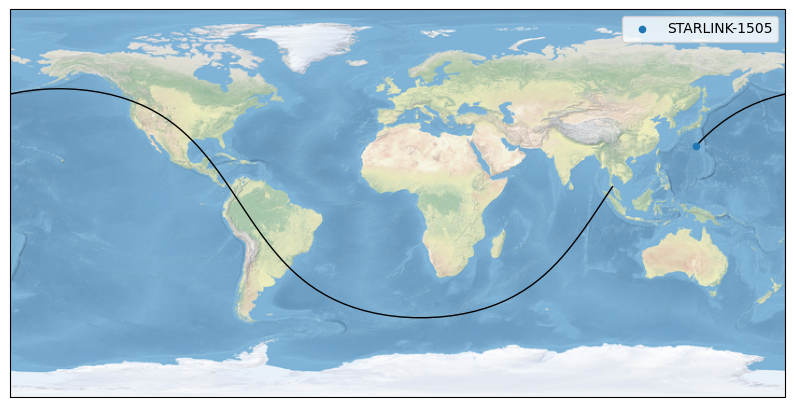

In [5]:
predict_track(mins=90, n=1)

Matplotlib by default is designed to plot in traditional grid spaces. In order to display data on a map, we have to have a base map with matching projection. Luckily, a library called Cartopy exists that is designed to process geospatial data for mapping with Matplotlib.

We start by defining the Cartopy coordinate reference system (CCRS) objects. These tell Cartopy what coordinate reference system (CRS) our data is using.

geod = ccrs.Geodetic()
proj = ccrs.LambertAzimuthalEqualArea(central_latitude=90.0)

The projection of our data is Lambert Azimuthal Equal Area with the center at the North Pole. 

Start: 2022-10-23  -  End: 2022-10-24

Satellite: STARLINK-1007
Orbits: ~15


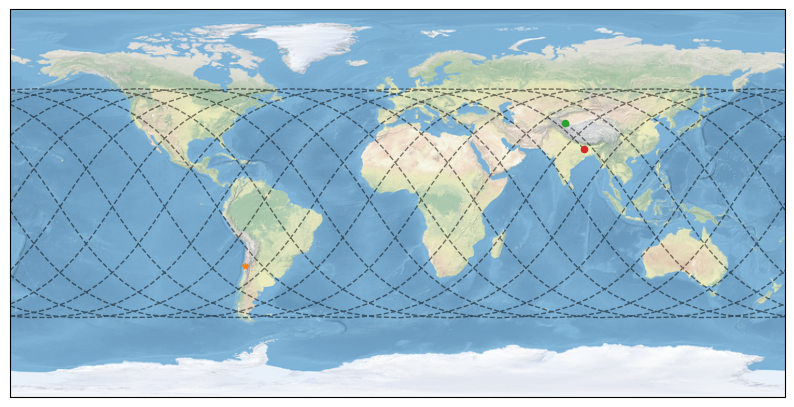

In [6]:
import pytz
import cartopy.feature as Cfeature
import datetime as dt
from skyfield.api import load, wgs84, EarthSatellite, S, W

# Scrape TLEs
url = 'http://celestrak.com/NORAD/elements/supplemental/starlink.txt'
sats = load.tle_file(url)
sat = sats[0]

# Projection map of Earth
fig = plt.figure(figsize=[10,15])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.stock_img()

# # Add coastlines, land, and ocean
# ax.coastlines(resolution='50m')
# ax.add_feature(Cfeature.LAND, zorder=0)
# ax.add_feature(Cfeature.OCEAN, zorder=0)

# Timescales
mins = 1440
ts = load.timescale()
tz = pytz.timezone('UTC')
st = tz.localize(dt.datetime(2022, 10, 23))
ed = st + dt.timedelta(days=1)
t0 = ts.utc(st)
t1 = ts.utc(st + dt.timedelta(minutes=mins))
times = ts.linspace(t0, t1, 722)
print(f'Start: {st:%Y-%m-%d}  -  End: {ed:%Y-%m-%d}\n')
print(f'Satellite: {sat.name}')
print(f'Orbits: ~{int(np.floor(mins/95))}')

# Calculate the subpoints
geocentric = sats[0].at(times)
subpoints = wgs84.subpoint_of(geocentric)
lons = subpoints.longitude.degrees
lats = subpoints.latitude.degrees

plt.plot(lons, lats, c='k', alpha=0.5, zorder=0, transform=ccrs.Geodetic(), lw=1, ls='--')
plt.scatter(lons[0],  lats[0],  c='C2', s=20, zorder=1)
plt.scatter(lons[-1], lats[-1], c='C3', s=20, zorder=1)

lasilla = wgs84.latlon(latitude_degrees=29.26111*S, longitude_degrees=70.73139*W, elevation_m=2400)
plt.scatter(lasilla.longitude.degrees, lasilla.latitude.degrees, c='C1', marker='*', s=20, zorder=1)

plt.show()

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from skyfield.api import load, EarthSatellite

# fig = plt.figure(figsize=[10, 8])
# ax  = fig.add_subplot(1, 1, 1, projection='3d')

# degs = np.pi/180
# rads = 180/np.pi

# sat = sats[0]
# ss = load('de421.bsp')
# earth = ss['earth']

# ts = load.timescale()
# hrs = np.arange(0, 3, 0.01)
# t = ts.utc(2022, 10, 23, hrs)
# position = sat.at(t).position.km
# ecliptic = sat.at(t).ecliptic_position().km

# R_earth = 6371.
# theta = np.linspace(0, 2*np.pi, 100)

# cth, sth, zth = [f(theta) for f in (np.cos, np.sin, np.zeros_like)]

# lons = []
# lon0 = R_earth * np.vstack((cth, zth, sth))
# for phi in rads*np.arange(0, 180, 15):
#     cph, sph = [f(phi) for f in (np.cos, np.sin)]
#     lon = np.vstack((lon0[0]*cph - lon0[1]*sph, lon0[1]*cph + lon0[0]*sph, lon0[2]))
#     lons.append(lon)

# lats = []
# lat0 = R_earth * np.vstack((cth, sth, zth))
# for phi in rads*np.arange(-75, 90, 15):
#     cph, sph = [f(phi) for f in (np.cos, np.sin)]
#     lat = R_earth*np.vstack((cth*cph, sth*cph, zth+sph))
#     lats.append(lat)

# x, y, z = position
# ax.plot(x, y, z, c='C3')
# for x, y, z in lons:
#     ax.plot(x, y, z, '-C0', alpha=0.3)
# for x, y, z in lats:
#     ax.plot(x, y, z, '-C0', alpha=0.3)

# # Radius and altitude of satellite
# R_sat = np.sqrt((position**2).sum(axis=0))
# Z_sat = R_sat - R_earth 

# plt.figure()
# #plt.plot(hrs, R_sat)
# plt.plot(hrs, Z_sat, c='C2')
# plt.xlabel('hours', fontsize=14)
# plt.ylabel('Altitude (km)', fontsize=14)

# plt.show()

In 3D space, a point on the surface of a sphere can be defined by its spherical coordinates (r, theta, phi), where r is the radius of the sphere, theta is the angle between the positive x-axis and the projection of the point onto the xy-plane, and phi is the angle between the positive z-axis and the point.

To create a surface plot of a sphere, we can parameterize it using theta and phi. However, we need to create a meshgrid of theta and phi values to define the coordinates of the points on the surface. This is where u and v come in - u and v are the two-dimensional grids of values that define the spherical coordinates of the points on the surface of the sphere.

Meshgrid of 20 by 10 points, where u corresponds to theta and v corresponds to phi. u ranges from 0 to 2π, which corresponds to a full revolution around the sphere, while v ranges from 0 to π, which corresponds to half a revolution from the north pole to the south pole.

Using u and v, we can compute the Cartesian coordinates (x, y, z) of each point on the surface of the sphere as:

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skyfield.api import load, wgs84, EarthSatellite, S, W

%matplotlib qt

url = 'https://celestrak.org/NORAD/elements/supplemental/starlink.txt'
sats = load.tle_file(url)
sat = sats[0]

R_earth = 6371.
ax = plt.figure(figsize=[10,8]).add_subplot(projection='3d')
ax.xaxis._axinfo['grid'].update({'linewidth':0.1})
ax.yaxis._axinfo['grid'].update({'linewidth':0.1})
ax.zaxis._axinfo['grid'].update({'linewidth':0.1})

ts = load.timescale()
hrs = np.arange(0, 1.6, 0.01)
t = ts.utc(2022, 10, 23, hrs)
position = sat.at(t).position.km

## Spherical coords --> (r, theta, phi) ... create meshgrid of n by m points (u=theta, v=phi)
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]

## Cartesian coords of each point on the surface of the sphere
x = R_earth * np.cos(u) * np.sin(v)
y = R_earth * np.sin(u) * np.sin(v)
z = R_earth * np.cos(v)
ax.plot_surface(x, y, z, color='C0', alpha=0.1)
ax.plot_wireframe(x, y, z, rstride=1, cstride=1, color='C0', alpha=0.05)

## Create a plane going through the Equator
X, Y = np.meshgrid(np.linspace(-R_earth, R_earth, 10), np.linspace(-R_earth, R_earth, 10))
Z = np.zeros_like(X)
ax.plot_surface(X, Y, Z, color='C9', alpha=0.3)

## Create a plane going through the axis of rotation of Earth 
adj = R_earth * np.cos(np.radians(66.5)) #90-23.5
X, Y = np.meshgrid(np.linspace(-R_earth, R_earth, 10), np.linspace(-adj, adj, 10))
Z = Y * np.tan(np.radians(66.5)) 
ax.plot_surface(X, Y, Z, color='C4', alpha=0.3)

## Satellite track
x, y, z = position
ax.plot(x, y, z, c='C3', ls='--')
ax.scatter(x[0], y[0], z[0], s=25, c='C2')
ax.scatter(x[-1], y[-1], z[-1], s=25, c='C3')

## Overplot MASCARA
mas_lon = -70.73139 
mas_lat = -29.26111 
mas_alt = 2.4
theta = np.pi/2 - np.radians(mas_lat)
phi = np.radians(mas_lon)
r = R_earth + mas_alt
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)
ax.scatter(x, y, z, marker='*', s=100, c='C1')

ele = ax.elev
azm = ax.azim
print(ele, azm)
ax.view_init(elev=5, azim=-15)

ax.set_axis_off()
plt.show()

30 -60


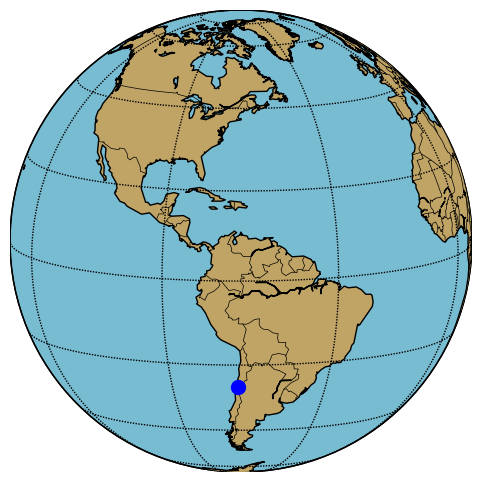

In [16]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(9,6))

# set perspective angle
lat_viewing_angle = 10
lon_viewing_angle = -70

# define color maps for water and land
ocean_map = (plt.get_cmap('ocean'))(210)
cmap = plt.get_cmap('gist_earth')

# call the basemap and use orthographic projection at viewing angle
m = Basemap(projection='ortho', lat_0=lat_viewing_angle, lon_0=lon_viewing_angle)    

# coastlines, map boundary, fill continents/water, fill ocean, draw countries
m.drawcoastlines()
m.drawmapboundary(fill_color=ocean_map)
m.fillcontinents(color=cmap(200),lake_color=ocean_map)
m.drawcountries()

# latitude/longitude line vectors
lat_line_range = [-90,90]
lat_lines = 8
lat_line_count = (lat_line_range[1]-lat_line_range[0])/lat_lines

merid_range = [-180,180]
merid_lines = 8
merid_count = (merid_range[1]-merid_range[0])/merid_lines

m.drawparallels(np.arange(lat_line_range[0],lat_line_range[1],lat_line_count))
m.drawmeridians(np.arange(merid_range[0],merid_range[1],merid_count))

x, y = m(lasilla.longitude.degrees, lasilla.latitude.degrees)
m.plot(x, y, 'bo', markersize=10)

plt.show()

## Different Inclinations

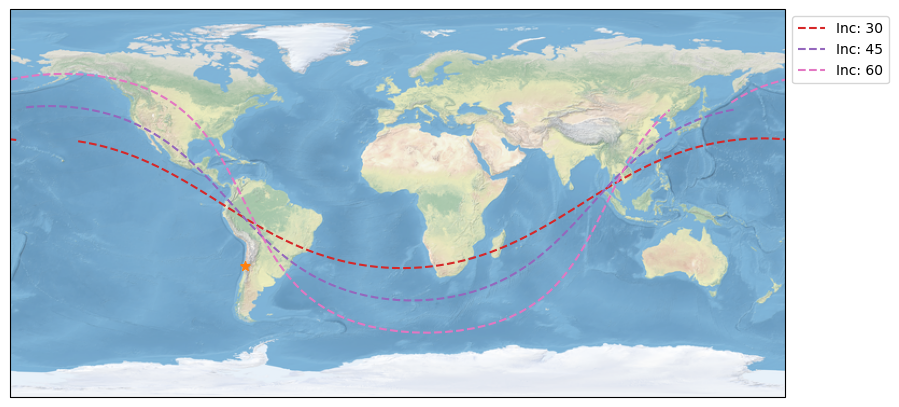

In [18]:
def inclinations(mins=95, inclinations=[30,45,60]):
    %matplotlib inline
    
    plt.figure(figsize=[10,15])
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()

    ts  = load.timescale()
    now = ts.now()
    dates = ts.utc(now.utc[0], now.utc[1], now.utc[2], now.utc[3], range(mins)) 
    
    line0 = "STARLINK-4444"           
    line1 = "1 99999U 23049A   23049.11111111  .00000000  00000-0  50000-4 0    05"
    
    for inc in inclinations:
        line2 = f"2 99999  {inc}  50.0000 0000001 180.0000 270.0000 15.10800000    03"
        sat = EarthSatellite(line1, line2, line0, ts)
        lats = []
        lons = []
        for time in dates:
            geocentric = sat.at(time)  
            lat, lon = wgs84.latlon_of(geocentric)
            lats.append(lat.degrees)
            lons.append(lon.degrees)

        plt.plot(lons, lats, c=f'C{str(inc)[0]}', label=f'Inc: {inc}', ls='--', zorder=0, transform=ccrs.Geodetic())
        ax.legend(bbox_to_anchor=(1.0, 1.0))
    
    lasilla = wgs84.latlon(latitude_degrees=29.26111*S, longitude_degrees=70.73139*W, elevation_m=2400)
    plt.scatter(lasilla.longitude.degrees, lasilla.latitude.degrees, c='C1', marker='*', s=50)
    plt.show()
    
inclinations()

### Coverage of MASCARA on map

$53^{\circ} × 74^{\circ}$ per camera and an image scale of ∼1' per pixel

The La Silla station observes the sky between $−90^{\circ} < \delta < 40^{\circ}$, providing the region with $−40^{\circ} < \delta < 0^{\circ}$  with coverage $\cdots \delta =$ declination

Each of the fixed cameras has a Field of View of 53 x 74 degrees, while the five cameras combined cover the entire sky down to 20 degrees from the horizon

Start: 2022-10-23  -  End: 2022-10-24

Satellite: STARLINK-1007
Orbits: ~15


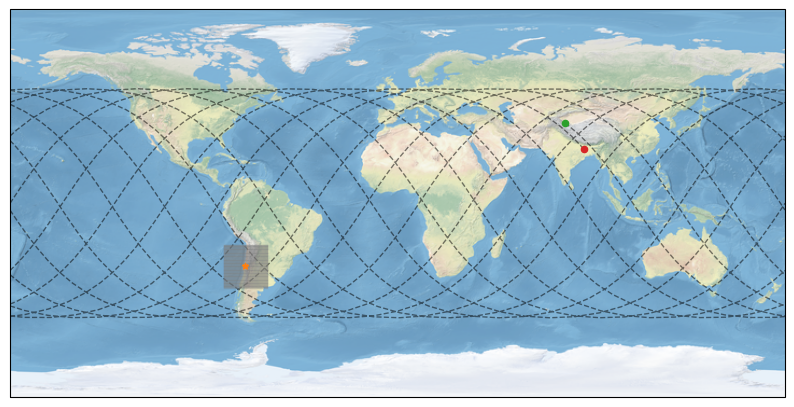

In [162]:
import pytz
import cartopy.feature as Cfeature
import datetime as dt
from skyfield.api import load, wgs84, EarthSatellite, S, W

# Scrape TLEs
url = 'http://celestrak.com/NORAD/elements/supplemental/starlink.txt'
sats = load.tle_file(url)
sat = sats[0]

# Projection map of Earth
fig = plt.figure(figsize=[10,15])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.stock_img()
# ax.coastlines(linewidth=0.15)
# ax.gridlines(draw_labels=False, linewidth=1, color='blue', alpha=0.3, linestyle='-')

# Timescales
mins = 1440
ts = load.timescale()
tz = pytz.timezone('UTC')
st = tz.localize(dt.datetime(2022, 10, 23))
ed = st + dt.timedelta(days=1)
t0 = ts.utc(st)
t1 = ts.utc(st + dt.timedelta(minutes=mins))
times = ts.linspace(t0, t1, 722)
print(f'Start: {st:%Y-%m-%d}  -  End: {ed:%Y-%m-%d}\n')
print(f'Satellite: {sat.name}')
print(f'Orbits: ~{int(np.floor(mins/95))}')

# Calculate the subpoints
geocentric = sats[0].at(times)
subpoints = wgs84.subpoint_of(geocentric)
lons = subpoints.longitude.degrees
lats = subpoints.latitude.degrees

plt.plot(lons, lats, c='k', alpha=0.5, zorder=0, transform=ccrs.Geodetic(), lw=1, ls='--')
plt.scatter(lons[0],  lats[0],  c='C2', s=20, zorder=1)
plt.scatter(lons[-1], lats[-1], c='C3', s=20, zorder=1)

lasilla = wgs84.latlon(latitude_degrees=29.26111*S, longitude_degrees=70.73139*W, elevation_m=2400)
plt.scatter(lasilla.longitude.degrees, lasilla.latitude.degrees, c='C1', marker='*', s=20, zorder=1)


# Observtory location and field of view angle
obs_lat = -29.26111
obs_lon = -70.73139
fov_angle = 20

# fov_lat = 53
# fov_lon = 74

# Calculate the coordinates of the field of view
fov_lat, fov_lon = np.meshgrid(np.linspace(obs_lat-fov_angle/2, obs_lat+fov_angle/2, 100),
                               np.linspace(obs_lon-fov_angle/2, obs_lon+fov_angle/2, 100))
# Plot the field of view
plt.plot(fov_lon, fov_lat, c='grey', linewidth=1, alpha=0.3, zorder=0)

# ax.add_patch(plt.Rectangle((x1, y1), fov_x, fov_y, transform=proj, facecolor='none', edgecolor='r'))


# proj = ccrs.PlateCarree()
# fov_lat = 53.0
# fov_lon = 74.0
# fov_lat, fov_lon = np.meshgrid(np.linspace(obs_lat-fov_lat/2, obs_lat+fov_lat/2, 100),
#                                np.linspace(obs_lon-fov_lon/2, obs_lon+fov_lon/2, 100))
# fov_x, fov_y, _ = proj.transform_points(ccrs.Geodetic(), fov_lon, fov_lat).T
# ax.plot(fov_x, fov_y, color='r', linewidth=1)

# plt.savefig('caree_proj.png', dpi=300, format='png')

plt.show()

Start: 2022-10-23  -  End: 2022-10-24

Satellite: STARLINK-1007
Orbits: ~15


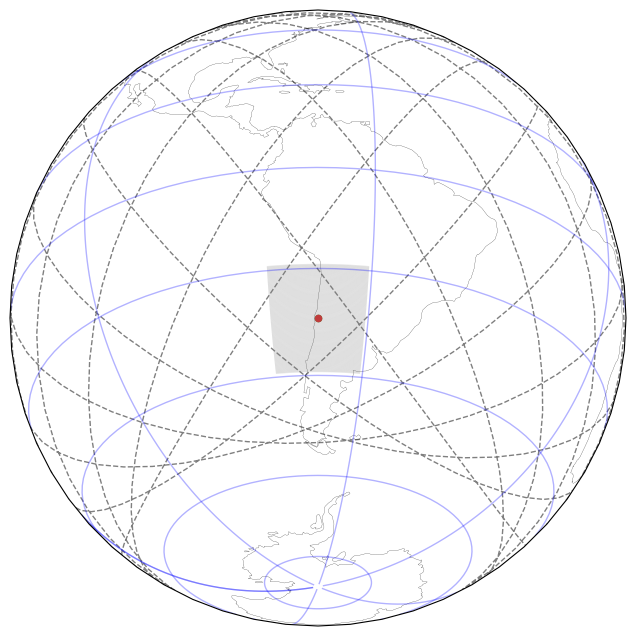

In [159]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math

%matplotlib inline

fig = plt.figure(figsize=(12,8))
obs_lat = -29.26111
obs_lon = -70.73139

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=obs_lon, central_latitude=obs_lat))
# ax.stock_img()
ax.coastlines(linewidth=0.15)
ax.gridlines(draw_labels=False, linewidth=1, color='blue', alpha=0.3, linestyle='-')

# Timescales
mins = 1440
ts = load.timescale()
tz = pytz.timezone('UTC')
st = tz.localize(dt.datetime(2022, 10, 23))
ed = st + dt.timedelta(days=1)
t0 = ts.utc(st)
t1 = ts.utc(st + dt.timedelta(minutes=mins))
times = ts.linspace(t0, t1, 722)
print(f'Start: {st:%Y-%m-%d}  -  End: {ed:%Y-%m-%d}\n')
print(f'Satellite: {sat.name}')
print(f'Orbits: ~{int(np.floor(mins/95))}')

# Calculate the subpoints
geocentric = sats[0].at(times)
subpoints = wgs84.subpoint_of(geocentric)
lons = subpoints.longitude.degrees
lats = subpoints.latitude.degrees

ax.plot(lons, lats, c='k', alpha=0.5, zorder=0, transform=ccrs.Geodetic(), lw=1, ls='--')
ax.scatter(lons[0],  lats[0],  c='C2', s=20, zorder=1)
ax.scatter(lons[-1], lats[-1], c='C3', s=20, zorder=1)

fov_lat = 53.0
fov_lon = 74.0

fov_ang = 20.0
fov_y, fov_x = np.meshgrid(np.linspace(obs_lat-fov_angle/2, obs_lat+fov_angle/2, 100),
                           np.linspace(obs_lon-fov_angle/2, obs_lon+fov_angle/2, 100))

# fov_y, fov_x = np.meshgrid(np.linspace(obs_lat-fov_lat/2, obs_lat+fov_lat/2, 100),
#                            np.linspace(obs_lon-fov_lon/2, obs_lon+fov_lon/2, 100))

ax.plot(fov_x, fov_y, transform=ccrs.Geodetic(), color='grey', linewidth=1, alpha=0.2)
# plt.savefig('ortho_proj_colors.png', dpi=300, format='png')
plt.show()

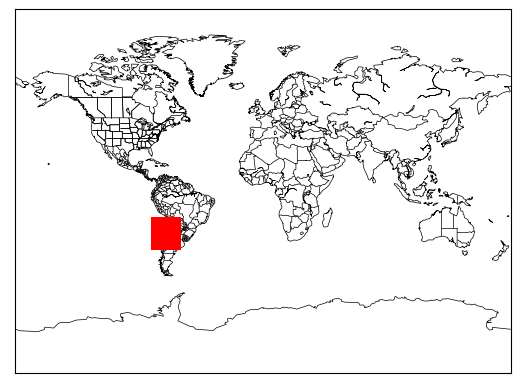

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Observtory location and field of view angle
obs_lat = -29.26111
obs_lon = -70.73139
fov_angle = 20.0

# Create a Basemap instance
m = Basemap(projection='mill', llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180)

# Draw coastlines, countries, and states
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawstates(linewidth=0.5)

# Calculate the coordinates of the field of view
fov_lat, fov_lon = np.meshgrid(np.linspace(obs_lat-fov_angle/2, obs_lat+fov_angle/2, 100),
                               np.linspace(obs_lon-fov_angle/2, obs_lon+fov_angle/2, 100))

# Convert the coordinates to map projection coordinates
x, y = m(fov_lon, fov_lat)

# Plot the field of view
m.plot(x, y, color='r', linewidth=2)

# Show the plot
plt.show()

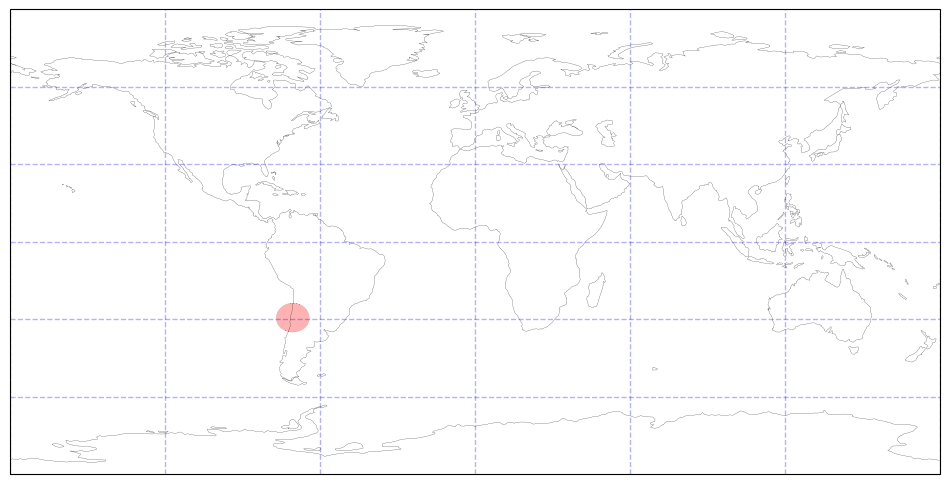

In [122]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math

%matplotlib inline

obs_lat = -29.26111
obs_lon = -70.73139

R_earth  = 6371000.
position = [30000., obs_lon, obs_lat]   # altitude (m), lat, long
radius = math.degrees(math.acos(R_earth / (R_earth + position[0])))

fig = plt.figure(figsize=(12,8))
img_extent = [-180, 180, -90, 90]

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), extent=img_extent)

# let's take 1 subtended degree = 112 km on earth surface (*** you set the value as needed ***)
ax.tissot(rad_km=radius*112, lons=position[1], lats=position[2], n_samples=64, \
             facecolor='red', edgecolor='black', linewidth=0.15, alpha=0.3)

ax.coastlines(linewidth=0.15)
ax.gridlines(draw_labels=False, linewidth=1, color='blue', alpha=0.3, linestyle='--')

plt.show()

Start: 2022-10-23  -  End: 2022-10-24

Satellite: STARLINK-1007
Orbits: ~15


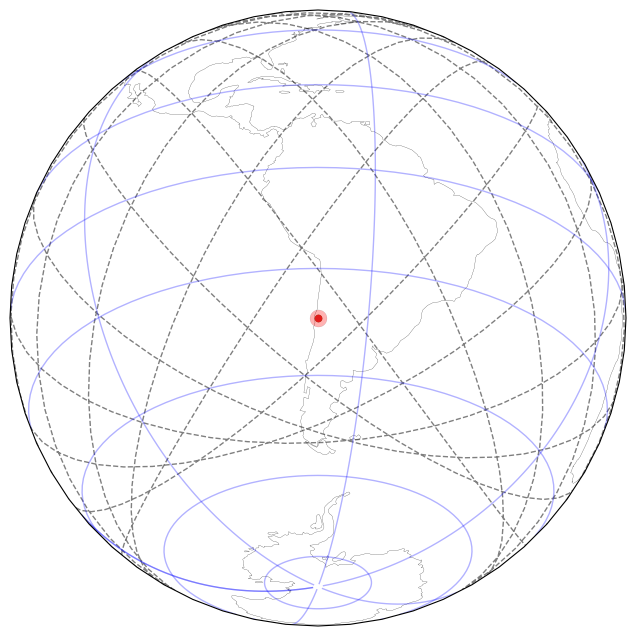

In [135]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math

fig = plt.figure(figsize=(12,8))
obs_lat = -29.26111
obs_lon = -70.73139

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=obs_lon, central_latitude=obs_lat))
ax.coastlines(linewidth=0.15)
ax.gridlines(draw_labels=False, linewidth=1, color='blue', alpha=0.3, linestyle='-')

# Timescales
mins = 1440
ts = load.timescale()
tz = pytz.timezone('UTC')
st = tz.localize(dt.datetime(2022, 10, 23))
ed = st + dt.timedelta(days=1)
t0 = ts.utc(st)
t1 = ts.utc(st + dt.timedelta(minutes=mins))
times = ts.linspace(t0, t1, 722)
print(f'Start: {st:%Y-%m-%d}  -  End: {ed:%Y-%m-%d}\n')
print(f'Satellite: {sat.name}')
print(f'Orbits: ~{int(np.floor(mins/95))}')

# Calculate the subpoints
geocentric = sats[0].at(times)
subpoints = wgs84.subpoint_of(geocentric)
lons = subpoints.longitude.degrees
lats = subpoints.latitude.degrees

ax.plot(lons, lats, c='k', alpha=0.5, zorder=0, transform=ccrs.Geodetic(), lw=1, ls='--')
ax.scatter(lons[0],  lats[0],  c='C2', s=20, zorder=1)
ax.scatter(lons[-1], lats[-1], c='C3', s=20, zorder=1)


R_earth  = 6371000.
position = [2400., obs_lon, obs_lat]   # altitude (m), lat, long
radius = math.degrees(math.acos(R_earth / (R_earth + position[0])))

# 1 subtended degree = 112 km on earth surface 
ax.tissot(rad_km=radius*112, lons=position[1], lats=position[2], n_samples=64, \
             facecolor='r', edgecolor='k', linewidth=0.15, alpha=0.3)

plt.show()

In [133]:
def beam_area(sigma_x, sigma_y):
    return 2*np.pi * sigma_x * sigma_y

def sigma(FWHM):
    return FWHM / np.sqrt(8*np.log(2))

sigma_x = sigma(53.)
sigma_y = sigma(74.)

beam = beam_area(sigma_x, sigma_y)
beam

4443.979119061564

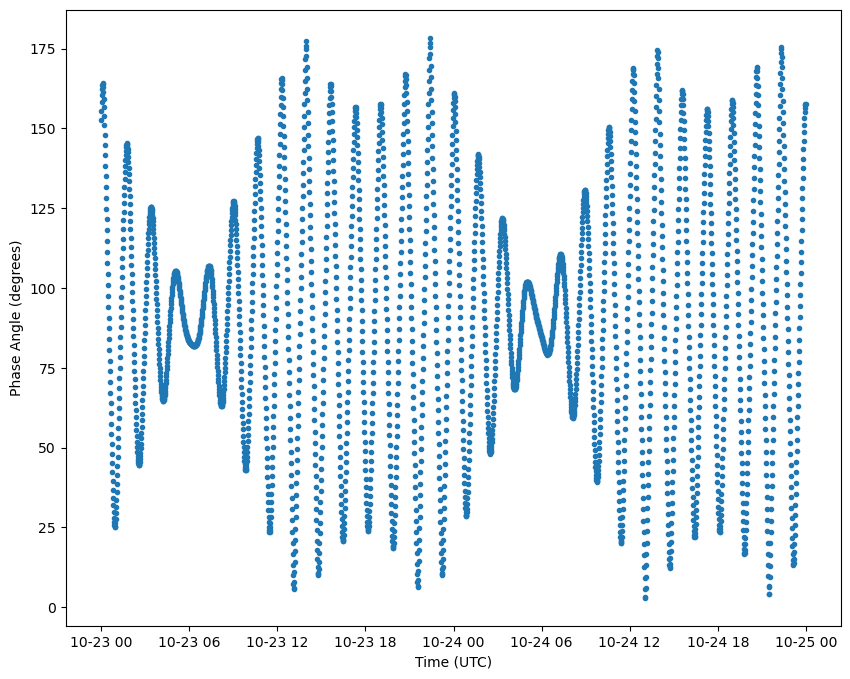

In [193]:
import numpy as np
from skyfield.api import Loader, Topos
import matplotlib.pyplot as plt

ts = load.timescale()
t0 = ts.utc(2022, 10, 23)
sat = sats[0]
obs = Topos('29.26111 S', '70.73139 W')

# Calculate the phase angle of the satellite over time
times = ts.utc(2022, 10, 23, 0, range(0, (24*60)*2, 1))

# Dist between sat and obs at each time using the Euclidean distance formula
pos_sat = sat.at(times).position.km
pos_obs = obs.at(times).position.km
dis_sat = np.sqrt(np.sum(pos_sat**2, axis=0))
dis_obs = np.sqrt(np.sum(pos_obs**2, axis=0))

# Now calculate the cosine of the phase angle at each time using the dot product formula
cos_phi = np.sum(pos_sat * pos_obs, axis=0) / (dis_sat * dis_obs)

# Convert to degrees
phi = np.degrees(np.arccos(cos_phi))

# Plot the phase angle over time
plt.figure(figsize=[10,8])
plt.plot_date(times.utc_datetime(), phi, markersize=3)
plt.xlabel('Time (UTC)')
plt.ylabel('Phase Angle (degrees)')
plt.show()